In [2]:
# Imports
import tensorflow as tf
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
#imports
import os
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.linear_model as skl
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
import matplotlib 
matplotlib.rcParams['text.usetex']=True
import matplotlib.pyplot as plt
from sklearn.utils import resample
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.animation import FuncAnimation

#newer imports
from random import random, seed
from sklearn.linear_model import SGDRegressor
import seaborn as sns


def plot_imshow(data, extent_vec, colours, fsize, figure_name, colourbar_label): 
	fig = plt.figure()
	axes = plt.gca()
	mynorm = matplotlib.cm.colors.Normalize(vmin=np.min(data), vmax=np.max(data))
	img = axes.imshow(data, extent=extent_vec, cmap=plt.get_cmap(colours), norm=mynorm)
	plt.xlabel(r'x, $1/L$', fontsize=fsize)
	plt.ylabel(r't, $L^2/\pi^2$', fontsize=fsize)
	plt.xticks(fontsize=fsize)
	plt.yticks(fontsize=fsize)
	cbar = fig.colorbar(img, ax=axes)
	cbar.set_label(colourbar_label, fontsize=fsize)
	cbar.ax.tick_params(labelsize=fsize)
	plt.savefig(figure_name, format="pdf")

In [9]:
class PDESolver(tf.keras.Sequential): 
    def __init__(self, hidden_layers, learning_rate=0.001): 
        super(PDESolver, self).__init__() # initiating sequential
        # Setting up neural network
        # Adding first layer
        self.add(tf.keras.layers.Dense(hidden_layers[0], input_shape=(2,), activation="linear")) # two inputs, x and t
        # Hidden layers
        for l in range(1, len(hidden_layers)): 
            self.add(tf.keras.layers.Dense(hidden_layers[l], activation="sigmoid"))
        # Output layer
        self.add(tf.keras.layers.Dense(1, activation="linear"))
        
        # Cost function
        self.cost_function = tf.keras.losses.MeanSquaredError()
        # Optimizer
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
    def train(self, x, t, iterations): 
        x = x.reshape(-1, 1)
        t = t.reshape(-1, 1)
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        t = tf.convert_to_tensor(t, dtype=tf.float32)
        self.x = x
        self.t = t
        cost_iteration = np.zeros(iterations)
        n_iterations = np.zeros(iterations)
        for i in range(iterations): 
            cost, gradients = self.gradients()
            n_iterations[i] = i
            cost_iteration[i] = cost
            self.optimizer.apply_gradients(zip(gradients, self.trainable_variables)) 
            if (i==int(iterations/5)): 
                print("A fifth of iterations done.")
            if (i==int(2*iterations/5)): 
                print("Two fifths of iterations done.")
            if (i==int(3*iterations/5)): 
                print("Three fifths of iterations done.")
            if (i==int(4*iterations/5)): 
                print("Four fifths of iterations done.")
                
            
        print("Initial cost: ", cost_iteration[0])
        print("Final cost: ", cost_iteration[-1])
        return cost_iteration, n_iterations
        
    def gradients(self): 
        with tf.GradientTape() as g: 
            cost = self.costs()
        gradient = g.gradient(cost, self.trainable_variables)
        return cost, gradient
    
    
    def costs(self):
        x = self.x
        t = self.t
        with tf.GradientTape() as g: 
            g.watch(x)
            with tf.GradientTape(persistent=True) as gg: 
                gg.watch([x, t])
                function = self.trial_function(train=True)
            ddx = gg.gradient(function, x)
            ddt = gg.gradient(function, t)
        d2dx2 = g.gradient(ddx, x)
        difference = d2dx2-ddt # Value of the differential equation
        cost = self.cost_function(0.0, difference) # Mean square error
        return cost
        
    def trial_function(self, train):
        x = self.x
        t = self.t
        x_input = tf.concat([x,t], 1)
        # u(x, 0) = sin(pi*x)
        # u(0, t) = 0
        # u(1, t) = 0
        # x, t in [0,1]
        # h1(x,t) = (1-t)*sin(pi*x)
        # h2(x,t) = (1-x)xtN(P)
        trial_f = (1-t)*tf.sin(np.pi*x) + (1-x)*x*t*self(x_input, training=train)
        return trial_f
    
    def predict(self, x, t): 
        x = x.reshape(-1, 1)
        t = t.reshape(-1, 1)
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        t = tf.convert_to_tensor(t, dtype=tf.float32)
        self.x = x
        self.t = t
        prediction = self.trial_function(train=False)
        return prediction
    
        

A fifth of iterations done.
Two fifths of iterations done.
Three fifths of iterations done.
Four fifths of iterations done.
Initial cost:  12.917667388916016
Final cost:  0.001799441291950643


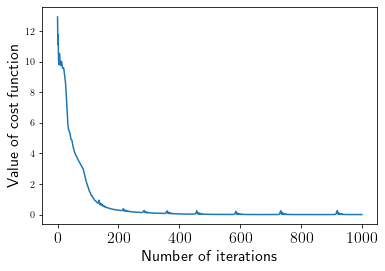

In [15]:
seed = 1132
tf.random.set_seed(seed)
np.random.seed(seed)
fsize = 16
# Initializing grid
N = 20
x = np.linspace(0,1,N)
t = np.linspace(0,1,N)
mx, mt = np.meshgrid(x,t)
x = mx.ravel()
t = mt.ravel()

hidden_layers = [100, 100, 100, 100]
learning_rate = 0.01

nn = PDESolver(hidden_layers=hidden_layers, learning_rate=learning_rate)
cost, iterations = nn.train(x=x, t=t, iterations=1000)

plt.plot(iterations, cost)
plt.xlabel("Number of iterations", fontsize=fsize)
plt.ylabel("Value of cost function", fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.savefig("costvsiterationsDE.pdf", format="pdf")
plt.show()

(100, 100)


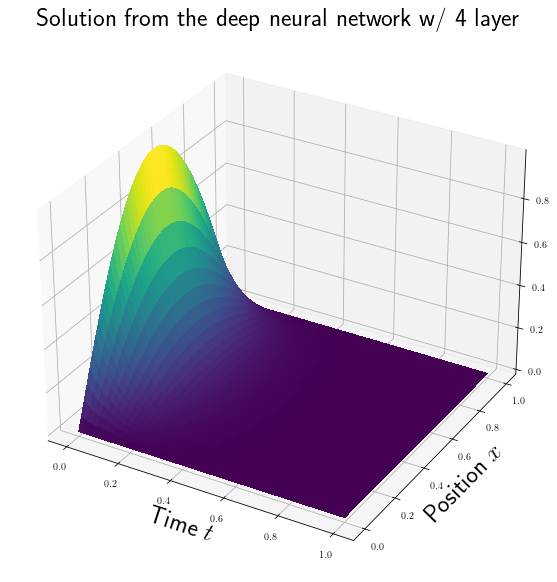

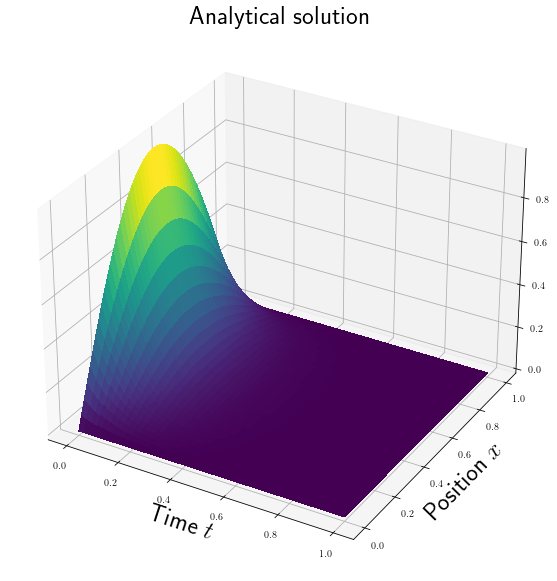

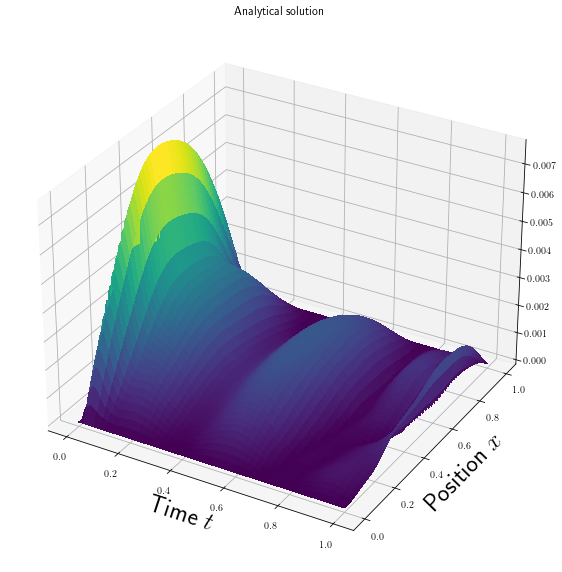

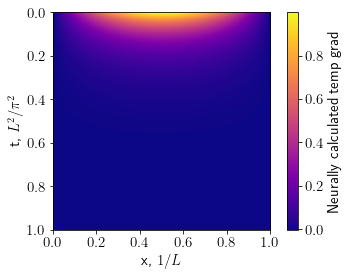

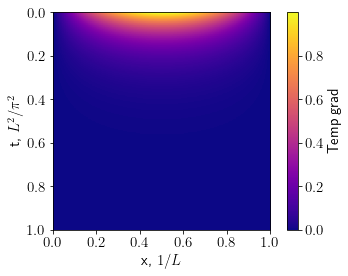

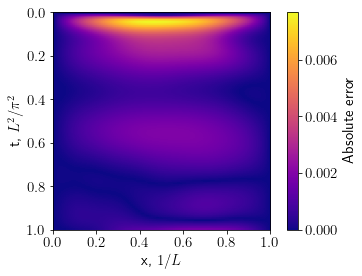

In [14]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

N = 100
x = np.linspace(0, 1, N)
t = np.linspace(0, 1, N)
mx, mt = np.meshgrid(x,t)
x = mx.ravel()
t = mt.ravel()
d3s = 25

def analytical_solution(x, t): 
    return np.sin(np.pi*x)*np.exp(-np.pi**2*t)

u_analytic = analytical_solution(mx, mt)
f_pred = nn.predict(x, t)
u_nn = tf.reshape(f_pred, (N, N))
difference = (u_nn-u_analytic)
print(u_nn.shape)
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.set_title('Solution from the deep neural network w/ %d layer'% 4, fontsize=d3s)
s = ax.plot_surface(mt,mx,u_nn,linewidth=0,antialiased=False,cmap=cm.viridis)
ax.set_xlabel('Time $t$', fontsize=d3s)
ax.set_ylabel('Position $x$', fontsize=d3s)
plt.savefig("nnsolutionDE.pdf", format="pdf")


fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.set_title('Analytical solution', fontsize=d3s)
s = ax.plot_surface(mt, mx,u_analytic,linewidth=0,antialiased=False,cmap=cm.viridis)
ax.set_xlabel('Time $t$', fontsize=d3s)
ax.set_ylabel('Position $x$', fontsize=d3s)
plt.savefig("analyticalsolutionDE.pdf", format="pdf")

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.set_title('Analytical solution')
s = ax.plot_surface(mt, mx,abs(difference),linewidth=0,antialiased=False,cmap=cm.viridis)
ax.set_xlabel('Time $t$', fontsize=d3s)
ax.set_ylabel('Position $x$', fontsize=d3s);


plot_imshow(u_nn, [0, 1.0, 1.0, 0], "plasma", 15, "nn.pdf", "Neurally calculated temp grad")
plot_imshow(u_analytic, [0, 1.0, 1.0, 0], "plasma", 15, "analytic_solution.pdf", "Temp grad")
plot_imshow(abs(u_nn-u_analytic), [0, 1.0, 1.0, 0], "plasma", 15, "absolute_error.pdf", "Absolute error")

[1 2 3]
[[1]
 [2]
 [3]]
[[1]
 [2]
 [3]]
